In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Fri Sep 30 11:53:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers tokenizers -q

In [4]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Read Dataset

In [5]:
# csv_file_path = '../input/yelp.csv' #local machine

csv_file_path = '/content/drive/MyDrive/YT-Datasets/Yelp-Review-Transformers-Deep_Dive-BOOK/yelp.csv' # G-Drive

# csv_file_path = '/kaggle/input/yelp-reviews-dataset/yelp.csv'


In [6]:
df = pd.read_csv(csv_file_path)
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [7]:
sorted(df.stars.unique())

[1, 2, 3, 4, 5]

In [8]:

# Map sentiment scores to categories
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4

    
# df['sentiment'] = df.score.apply(map_sentiment_scores)

df['stars'] = df.stars.apply(map_sentiment_scores)

In [9]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,4,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,4,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,3,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,4,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,4,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [10]:
sorted(df.stars.unique())

[0, 1, 2, 3, 4]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '1-Star'),
 Text(0, 0, '2-Star'),
 Text(0, 0, '3-Star'),
 Text(0, 0, '4-Star'),
 Text(0, 0, '5-Star')]

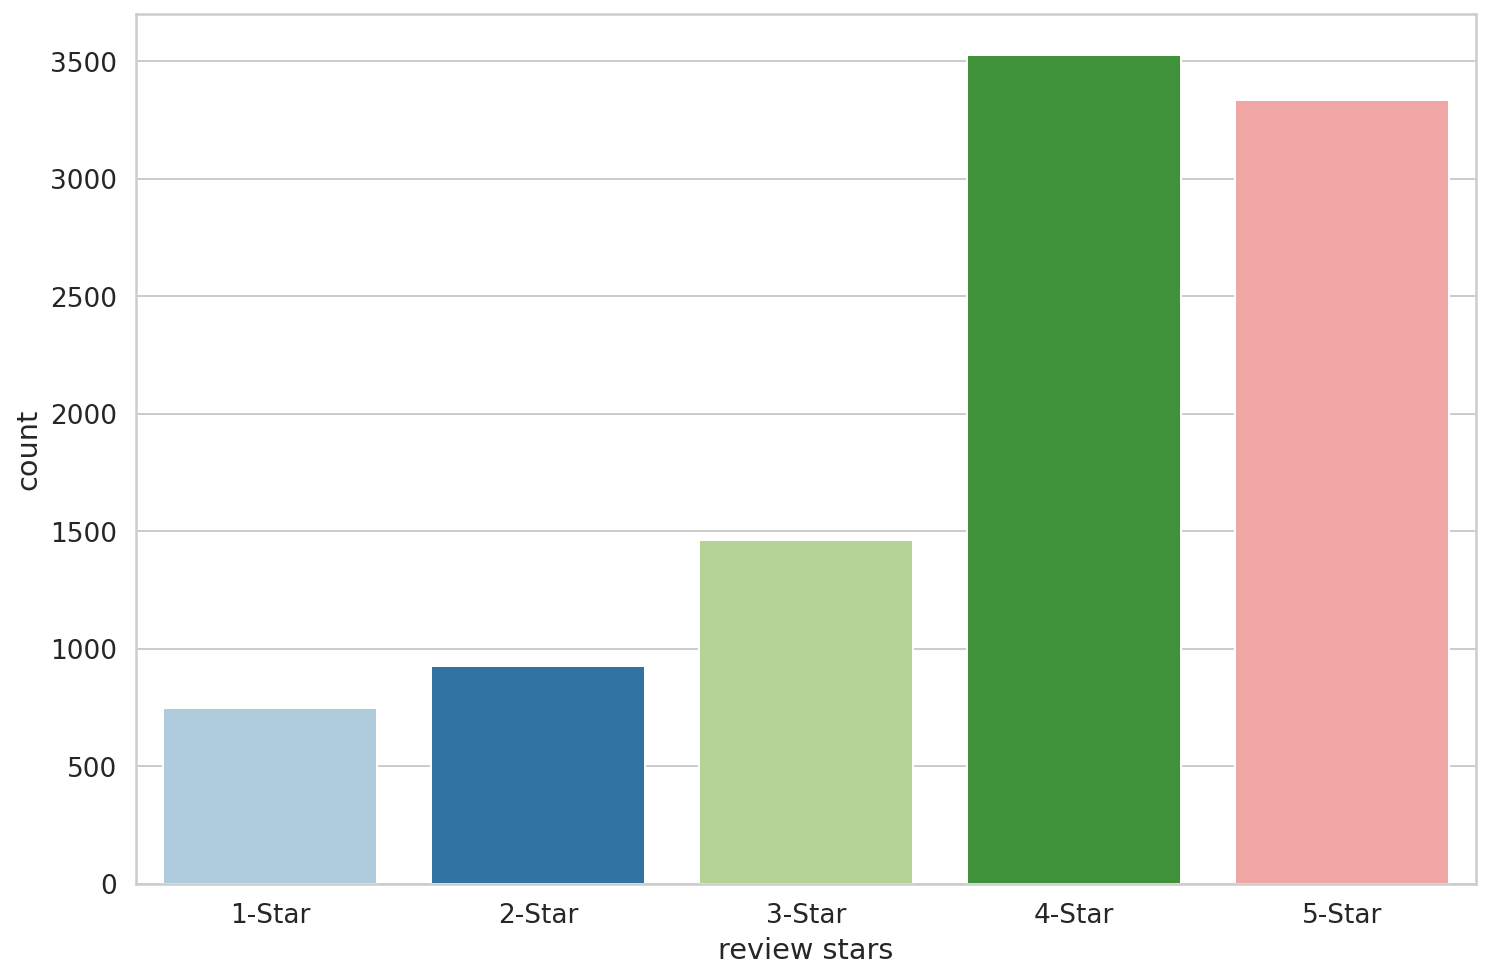

In [11]:
class_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star' ]

ax = sns.countplot(df.stars)
plt.xlabel('review stars')
ax.set_xticklabels(class_names)

## Got Error - `CUDA runtime error (59) : device-side assert triggered`

https://stackoverflow.com/a/55272357/1902852

This is usually an indexing issue.

For example, if your ground truth label starts at 1:

target = [1,2,3,4,5]


Then you should subtract 1 for every label instead so that:

target = [0,1,2,3,4]

### Further possible source of the Problem

https://builtin.com/software-engineering-perspectives/cuda-error-device-side-assert-triggered


### INCONSISTENCY BETWEEN THE NUMBER OF LABELS AND OUTPUT UNITS


### WRONG INPUT FOR THE LOSS FUNCTION

Loss functions have different ranges for the possible inputs that they can accept. If you choose an incompatible activation function for your output layer, it will trigger this error. For example, BCELoss()requires its input to be between zero and one. If the input (output from your model) is beyond the acceptable range for that particular loss function, the error will get triggered.

--------------------------


## `text` and 'stars` columns will be the features and targets respectively down below


```py
reviews = df.text.to_list(), 
targets = df.stars.to_list(), 

```

# Model

## Define Transformer and Tokenizer

In [12]:
pre_trained_model_ckpt = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

# Tokenization and encoding on a Sample Text

In [13]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt')  # Return PyTorch tensors)

print(f'Encoding keys: {encoding.keys()}')
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]
Encoding keys: dict_keys(['input_ids', 'attention_mask'])
17
tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102])
17
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
['[CLS]', 'when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', '[SEP]']


### EDA of token counts in the reviews dataset

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

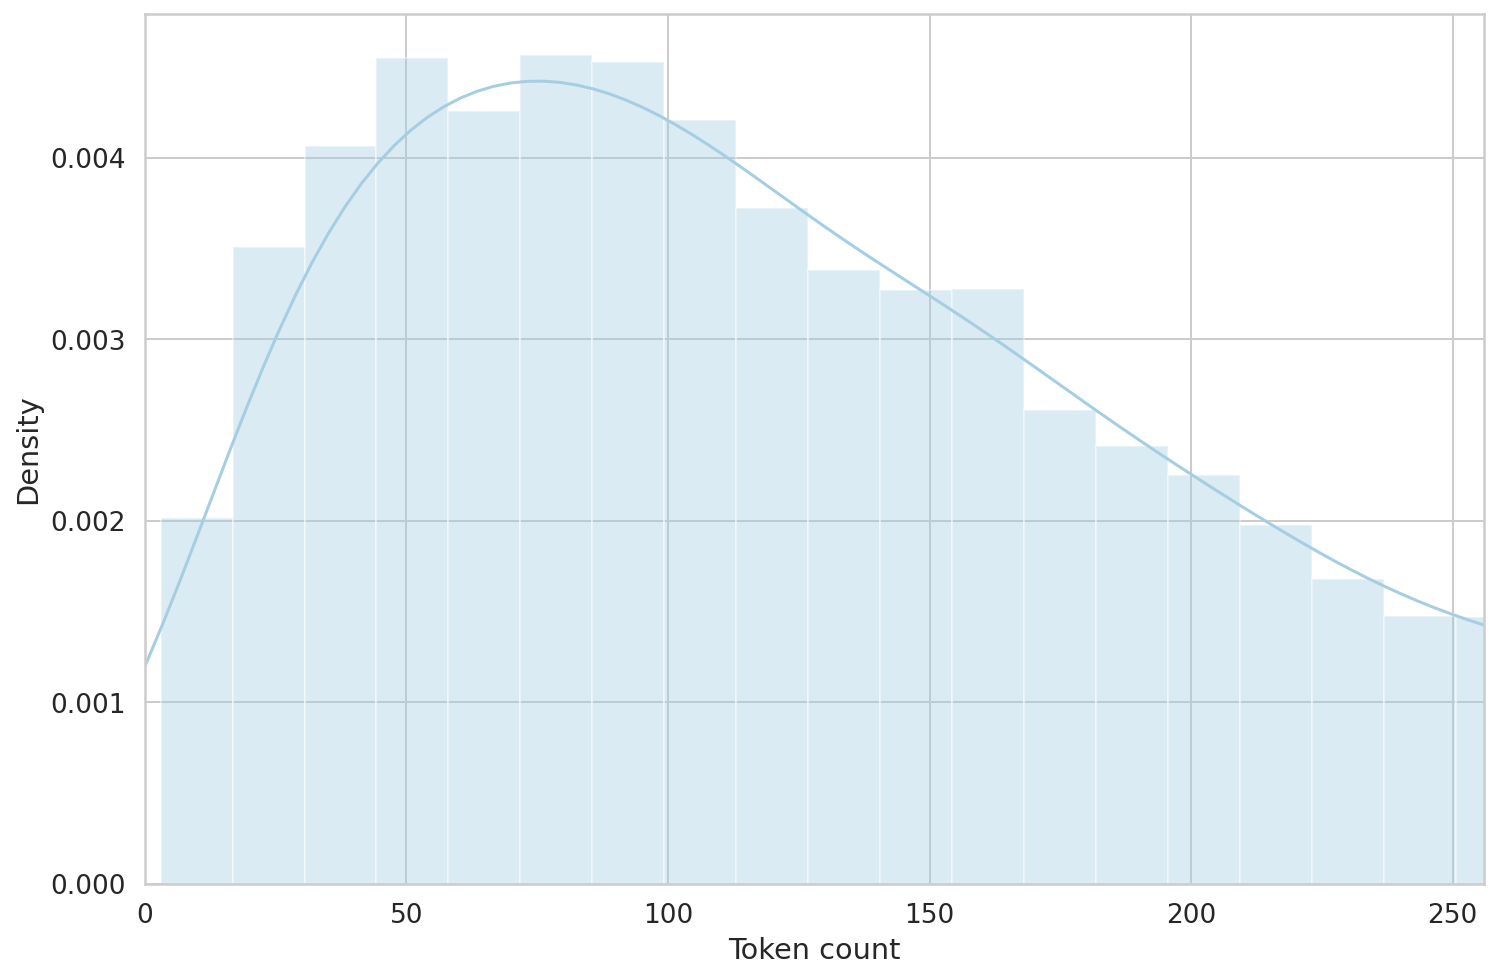

In [14]:
token_lens = []

for txt in df.text:
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))


sns.distplot(token_lens)

plt.xlim([0,256])

plt.xlabel('Token count')

# Dataset Utility Class

In [15]:
MAX_LEN = 160
BATCH_SIZE = 16


class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len, include_raw_text=False):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review, 
            add_special_tokens = True, 
            max_length = self.max_len, 
            return_token_type_ids = False, 
            return_attention_mask = True, 
            truncation = True,
            pad_to_max_length = True, 
            return_tensors = 'pt',)

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
        if self.include_raw_text:
            output['review_text'] = review
            
        return output 


def create_data_loader(df, tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, include_raw_text=False):
    ds = ReviewDataset(
        reviews = df.text.to_list(), 
        targets = df.stars.to_list(), 
        tokenizer = tokenizer, 
        max_len = max_len,
        include_raw_text = include_raw_text)
    return DataLoader(ds, batch_size=batch_size)

In [16]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(7000, 10) (1500, 10) (1500, 10)


In [17]:
train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer, include_raw_text=True)
test_data_loader = create_data_loader(df_test, tokenizer, include_raw_text=True)

In [18]:
for d in val_data_loader:
    print(d.keys())
    
# dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])

dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])
dict_keys(['input_ids', 'attention

In [19]:
#Testing to see if the data loader works appropriately
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Model Utility Class

In [20]:
bert_model = BertModel.from_pretrained(pre_trained_model_ckpt)

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trained_model_ckpt,return_dict=False)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask= attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)
  
    
model = SentimentClassifier(len(class_names))
model = model.to(device)

# An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids,attention_mask), dim = 1)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.trans

tensor([[0.0869, 0.1024, 0.2520, 0.3691, 0.1896],
        [0.1392, 0.1439, 0.3314, 0.1714, 0.2142],
        [0.1836, 0.1293, 0.3422, 0.1720, 0.1729],
        [0.1361, 0.1261, 0.2859, 0.2812, 0.1707],
        [0.0937, 0.1160, 0.1841, 0.2900, 0.3162],
        [0.1500, 0.1166, 0.2616, 0.2726, 0.1992],
        [0.1574, 0.1510, 0.2990, 0.2031, 0.1895],
        [0.1897, 0.1470, 0.3159, 0.1836, 0.1638],
        [0.1639, 0.1545, 0.2962, 0.1987, 0.1868],
        [0.1348, 0.1779, 0.2032, 0.2808, 0.2032],
        [0.1072, 0.0999, 0.3183, 0.1677, 0.3069],
        [0.1709, 0.1757, 0.2743, 0.1840, 0.1951],
        [0.1646, 0.1771, 0.2861, 0.1877, 0.1845],
        [0.1126, 0.1514, 0.2581, 0.3280, 0.1498],
        [0.1296, 0.1287, 0.2522, 0.2091, 0.2804],
        [0.1512, 0.1600, 0.2818, 0.2258, 0.1812]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

# Training

## Training Loop Utility Functions

In [21]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,4,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,4,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,3,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,4,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,4,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [22]:
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr= 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps=total_steps)

# For multi-class classification you would usually just use nn.CrossEntropyLoss 
loss_fn = nn.CrossEntropyLoss().to(device)


In [23]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model=model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets).cpu()
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions/n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _,preds = torch.max(outputs, dim = 1)

            loss = loss_fn(outputs, targets.detach())
            correct_predictions += torch.sum(preds == targets).cpu()
            losses.append(loss.item())
    return correct_predictions/n_examples, np.mean(losses)


## Training Loop

In [24]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  

Epoch 1/ 10
---------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 1.1854700380808687 accuracy 0.4690000116825104
Val loss 0.9844596303523855 accuracy 0.5473333597183228
Epoch 2/ 10
---------------
Train loss 0.9070859179921347 accuracy 0.6014285683631897
Val loss 0.9998326228654131 accuracy 0.562666654586792
Epoch 3/ 10
---------------
Train loss 0.7620897780950755 accuracy 0.683571457862854
Val loss 1.025649922325256 accuracy 0.5706666707992554
Epoch 4/ 10
---------------
Train loss 0.6423199128818838 accuracy 0.7412857413291931
Val loss 1.080071897899851 accuracy 0.5839999914169312
Epoch 5/ 10
---------------
Train loss 0.52731679267671 accuracy 0.8005714416503906
Val loss 1.1988709657750232 accuracy 0.5613333582878113
Epoch 6/ 10
---------------
Train loss 0.431269598299782 accuracy 0.8464285731315613
Val loss 1.3300835338044674 accuracy 0.5606666803359985
Epoch 7/ 10
---------------
Train loss 0.35640798953093894 accuracy 0.8768571615219116
Val loss 1.3362769482934729 accuracy 0.5753333568572998
Epoch 8/ 10
---------------
Train loss 0

(0.0, 1.0)

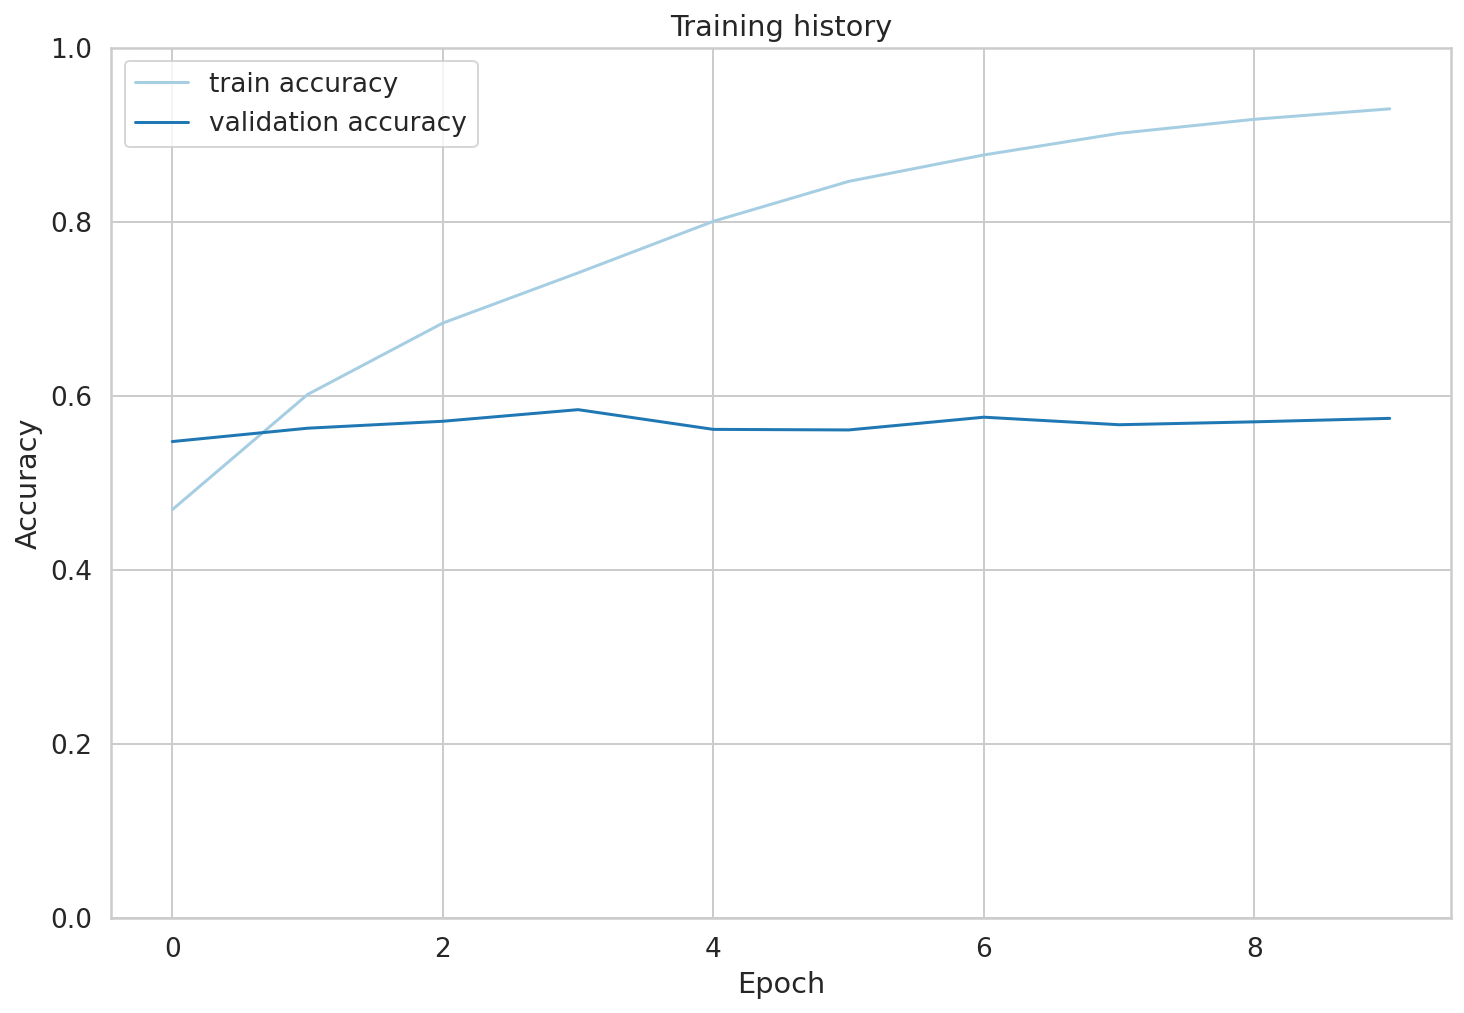

In [25]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])

## Visualizing Training/Validation Losses

In [26]:
len(class_names)

5

In [27]:
history['train_loss']

[1.1854700380808687,
 0.9070859179921347,
 0.7620897780950755,
 0.6423199128818838,
 0.52731679267671,
 0.431269598299782,
 0.35640798953093894,
 0.2962963273621177,
 0.25307960208658487,
 0.22381919460821914]

In [28]:
history['val_loss']

[0.9844596303523855,
 0.9998326228654131,
 1.025649922325256,
 1.080071897899851,
 1.1988709657750232,
 1.3300835338044674,
 1.3362769482934729,
 1.412549464785038,
 1.515986976154307,
 1.536134345734373]

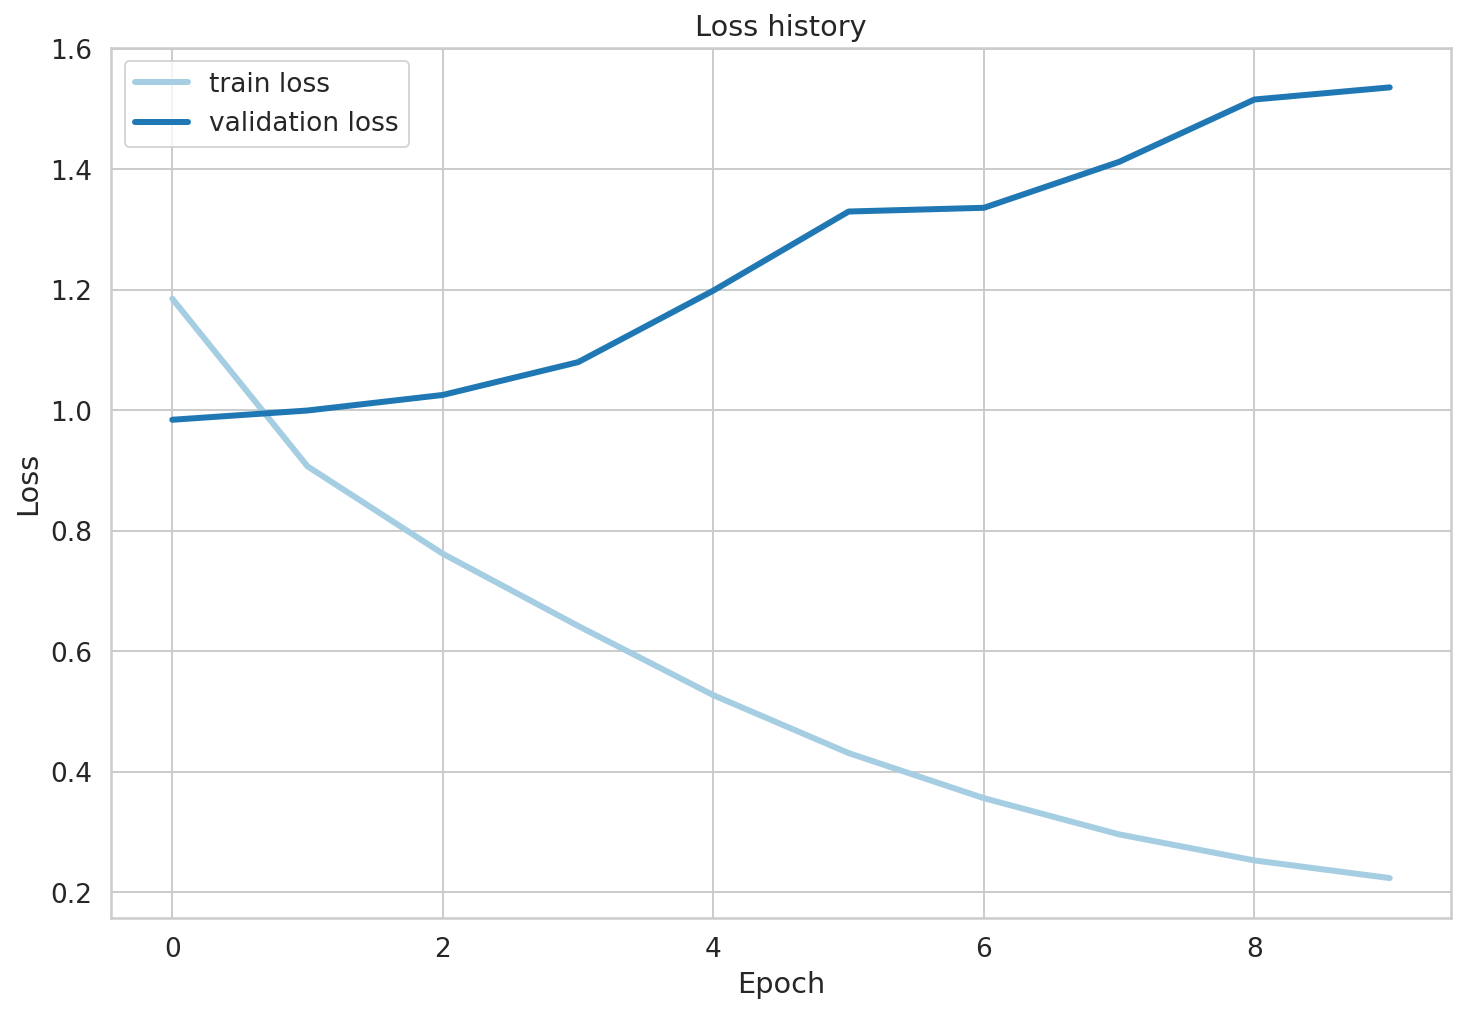

In [29]:
plt.plot(history['train_loss'], label='train loss',linewidth=3)
plt.plot(history['val_loss'], label='validation loss',linewidth=3)

plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1]);

In [30]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test Accuracy {test_acc.item()}')

Test Accuracy 0.5606666803359985


# Model Evaluation

              precision    recall  f1-score   support

      1-Star       0.70      0.55      0.61       100
      2-Star       0.40      0.41      0.40       110
      3-Star       0.45      0.38      0.41       231
      4-Star       0.55      0.56      0.56       567
      5-Star       0.63      0.68      0.65       492

    accuracy                           0.56      1500
   macro avg       0.54      0.52      0.53      1500
weighted avg       0.56      0.56      0.56      1500



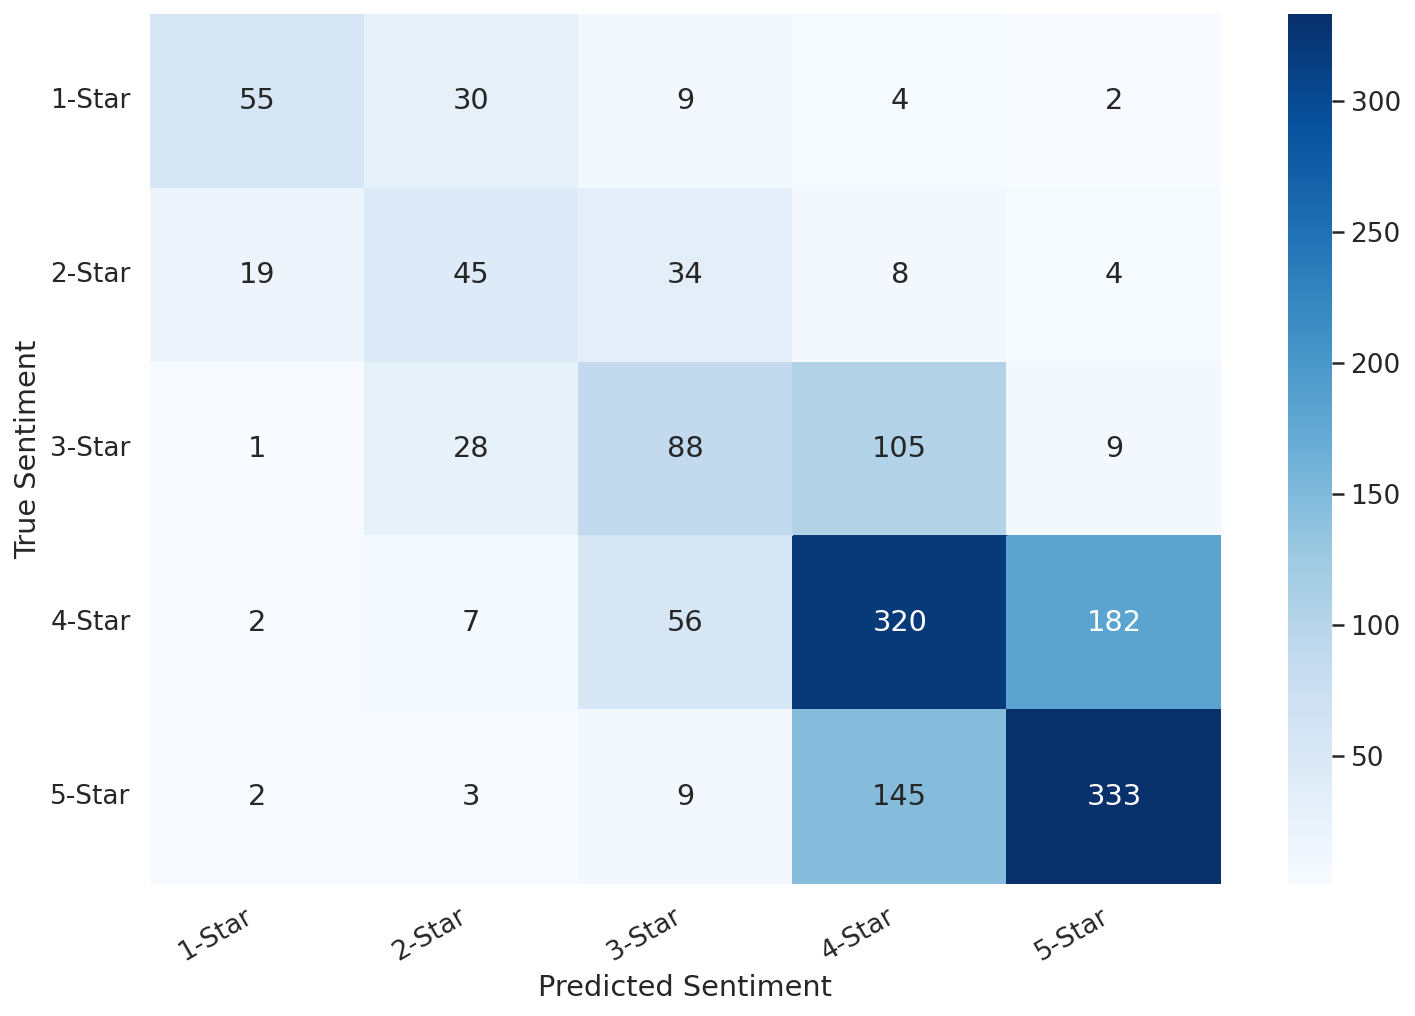

In [31]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
    
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

Good Date Night Spot!!!  Went here the other night for dinner and it
was really good. I had the steak and my wife had the casa dilla of the
day.  Both were cooked to perfection.  Sometimes nicer places have
really small portions and seem to pay more attention to how pretty the
dish is instead of how good it is but this place was spot on with both
presentation and taste. We did not have a reservation so we sat at the
bar which has full menu service.  The bar wraps around and near the
men's restroom there is some additional bar seats that nobody sits at.
I thought this area might have been a little more private than some of
the two person tables.  I also thought it was cool to be able to see
into the kitchen but that might only be appealing to me.  The
bartender was very knowledgeable and checked on us several times
during our meal.  This place has a good vibe for couples doing the
date night thing but there was also a table of 6 near us who were also
having a good time.  Cowboy Ciao is 

(0.0, 1.0)

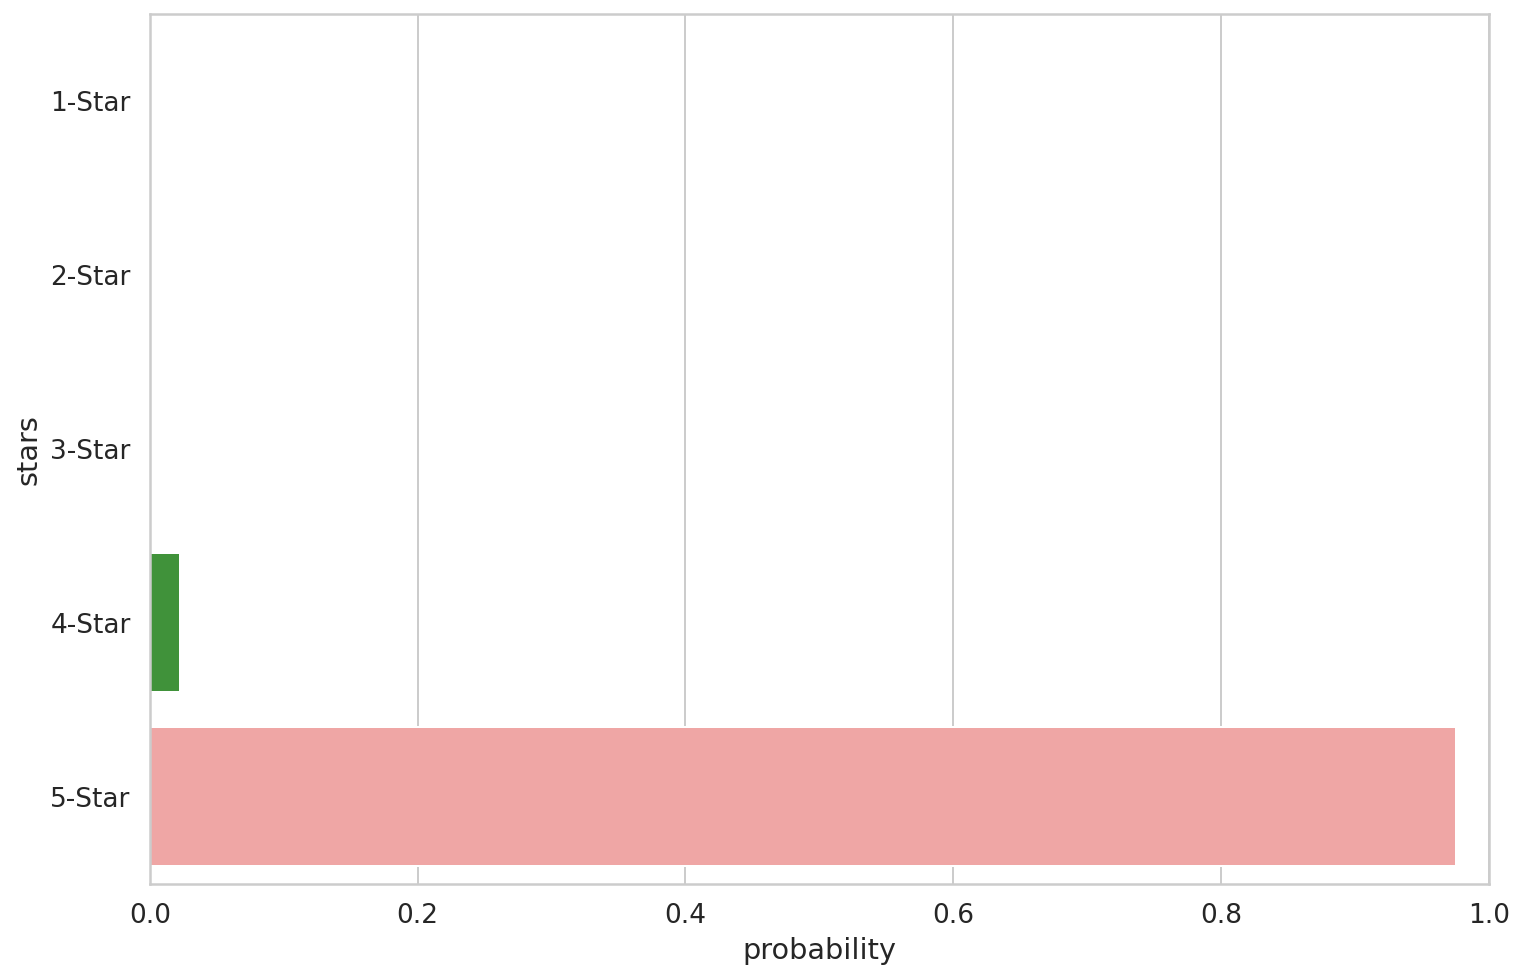

In [32]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names':class_names, 'values':y_pred_probs[idx]})
print("\n".join(wrap(review_text)))
print()
print(f'True Sentiment: {class_names[true_sentiment]}')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('stars')
plt.xlabel('probability')
plt.xlim([0,1])

In [33]:
review_text = "I could share photos seamlessly with this app"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')



Review text: I could share photos seamlessly with this app
Sentiment  : 5-Star


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [34]:
review_text = "I could share photos seamlessly with this app, but the UI could be better"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I could share photos seamlessly with this app, but the UI could be better
Sentiment  : 3-Star
